## Import functions

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import pypfopt
import itertools
import pypfopt
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.covariance import LedoitWolf
from pypfopt import objective_functions

## Data preparation

### FF48

In [2]:
df = pd.read_csv('Test_data/48_Industry_Portfolios_Daily_Clean.csv', index_col = 0)
df.rename(columns={"Average Value Weighted Returns -- Daily": "date"}, inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.loc[(df['date'] >= '1992-12-31') & (df['date'] <= '2022-12-31')]
df = df.set_index('date')
df = df/100
df.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
date,,,,,,,,,,,,,,,,,,,,,
1992-12-31,0.0111,-0.0081,0.0037,-0.0158,0.0037,0.0027,-0.0035,-0.0026,-0.0031,0.0027,...,0.0052,-0.0056,0.0046,-0.0027,0.0075,-0.0003,0.0002,0.0173,-0.0002,0.0002
1993-01-04,-0.0020,-0.0079,-0.0048,-0.0019,-0.0071,0.0027,-0.0027,0.0041,-0.0012,-0.0015,...,0.0094,0.0045,-0.0049,-0.0137,-0.0030,-0.0029,-0.0021,-0.0184,-0.0008,-0.0031
1993-01-05,-0.0025,-0.0143,-0.0146,-0.0140,-0.0133,0.0052,0.0026,-0.0005,0.0040,0.0022,...,0.0132,0.0041,0.0044,-0.0013,-0.0013,-0.0037,-0.0100,-0.0116,0.0005,0.0001
1993-01-06,0.0074,-0.0097,0.0139,-0.0009,-0.0306,0.0083,0.0137,0.0081,-0.0010,0.0004,...,0.0002,0.0069,0.0039,-0.0065,0.0043,0.0012,0.0029,-0.0014,0.0011,0.0023
1993-01-07,-0.0203,-0.0060,-0.0089,-0.0196,0.0013,-0.0134,-0.0095,-0.0036,-0.0096,0.0018,...,-0.0093,0.0011,-0.0043,-0.0102,-0.0029,-0.0151,-0.0026,0.0073,-0.0020,-0.0066


### FF-100

In [3]:
ff100 = pd.read_csv('Test_data/100_Portfolios_ME_INV_10x10_daily.csv')
ff100.rename(columns={"Unnamed: 0": "date"}, inplace=True)
ff100['date'] = pd.to_datetime(ff100['date'].astype(str), errors='coerce')
ff100 = ff100.loc[(ff100['date'] >= '1992-12-31') & (ff100['date'] <= '2022-12-31')]
ff100 = ff100.set_index('date')
ff100 = ff100.astype(float)/100
ff100

,SMALL LoINV,ME1 INV2,ME1 INV3,ME1 INV4,ME1 INV5,ME1 INV6,ME1 INV7,ME1 INV8,ME1 INV9,SMALL HiINV,...,BIG LoINV,ME10 INV2,ME10 INV3,ME10 INV4,ME10 INV5,ME10 INV6,ME10 INV7,ME10 INV8,ME10 INV9,BIG HiINV
date,,,,,,,,,,,,,,,,,,,,,
1992-12-31,0.0179,0.0180,0.0114,0.0160,0.0094,0.0131,0.0082,0.0165,0.0182,0.0188,...,-0.0075,-0.0026,-0.0125,-0.0025,-0.0050,-0.0070,-0.0068,-0.0094,-0.0151,-0.0057
1993-01-04,0.0086,-0.0022,0.0023,0.0017,0.0021,-0.0037,0.0005,0.0076,-0.0046,0.0067,...,0.0257,0.0031,0.0148,0.0020,0.0005,-0.0041,-0.0060,-0.0045,-0.0017,-0.0086
1993-01-05,0.0019,0.0111,0.0055,0.0160,-0.0045,-0.0046,0.0081,0.0138,-0.0055,0.0036,...,0.0108,0.0084,-0.0058,0.0023,-0.0095,-0.0040,0.0005,-0.0067,0.0020,-0.0033
1993-01-06,0.0117,0.0057,0.0100,0.0009,-0.0035,0.0197,0.0097,0.0055,0.0069,0.0133,...,-0.0068,0.0236,0.0005,0.0041,-0.0029,0.0003,-0.0030,-0.0093,0.0065,-0.0081
1993-01-07,-0.0043,0.0071,0.0045,0.0001,0.0129,-0.0028,-0.0005,0.0075,0.0055,-0.0015,...,-0.0213,-0.0086,-0.0132,-0.0079,-0.0043,-0.0119,-0.0061,-0.0129,-0.0092,-0.0100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.0030,0.0095,0.0099,0.0055,-0.0040,0.0026,0.0007,0.0097,0.0057,0.0004,...,0.0017,0.0038,0.0089,0.0093,0.0047,0.0028,0.0068,0.0001,0.0097,0.0013
2022-12-27,-0.0166,-0.0059,-0.0120,-0.0135,0.0063,-0.0069,-0.0158,-0.0015,-0.0164,-0.0266,...,0.0040,0.0015,0.0034,0.0042,-0.0022,-0.0053,-0.0063,-0.0173,-0.0095,-0.0302
2022-12-28,-0.0057,-0.0003,-0.0070,-0.0090,-0.0164,-0.0098,-0.0073,-0.0046,0.0001,-0.0003,...,-0.0112,-0.0095,-0.0108,-0.0109,-0.0066,-0.0201,-0.0101,-0.0035,-0.0111,-0.0115


In [41]:
sp500.columns.str.split(';')

Index([['Date', 'AAPL', 'ABBV', 'ABT', 'ACN', 'AGN', 'AIG', 'ALL', 'AMGN', 'AMZN', 'AXP', 'BA', 'BAC', 'BIIB', 'BK', 'BLK', 'BMY', 'BRK.B', 'C', 'CAT', 'CELG', 'CHTR', 'CL', 'CMCSA', 'COF', 'COP', 'COST', 'CSCO', 'CVS', 'CVX', 'DHR', 'DIS', 'DUK', 'DWDP', 'EMR', 'EXC', 'F', 'FB', 'FDX', 'FOX', 'FOXA', 'GD', 'GE', 'GILD', 'GM', 'GOOG', 'GOOGL', 'GS', 'HAL', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'JPM', 'KHC', 'KMI', 'KO', 'LLY', 'LMT', 'LOW', 'MA', 'MCD', 'MDLZ', 'MDT', 'MET', 'MMM', 'MO', 'MON', 'MRK', 'MS', 'MSFT', 'NEE', 'NKE', 'ORCL', 'OXY', 'PCLN', 'PEP', 'PFE', 'PG', 'PM', 'PYPL', 'QCOM', 'RTN', 'SBUX', 'SLB', 'SO', 'SPG', 'T', 'TGT', 'TWX', 'TXN', 'UNH', 'UNP', 'UPS', 'USB', 'UTX', 'V', 'VZ', 'WBA', ...]], dtype='object')

In [50]:
sp500 = pd.read_csv('Test_data/Sample_Data_SP500.csv', header=None)
#sp500['Address'].str.split(';', expand=True)
sp500 = sp500[0].str.split(';')
pd.DataFrame(sp500)

,0
0,"[Date, AAPL, ABBV, ABT, ACN, AGN, AIG, ALL, AM..."
1,"[2009-12-31, 26.986492, , 21.011253, 34.57748,..."
2,"[2010-01-04, 27.406532000000002, , 21.194162, ..."
3,"[2010-01-05, 27.453915000000002, , 21.022924, ..."
4,"[2010-01-06, 27.017222999999998, , 21.139675, ..."
...,...
1979,"[2017-11-08, 175.608719, 95.709999, 55.25, 144..."
1980,"[2017-11-09, 175.25, 95.889999, 55.450001, 143..."
1981,"[2017-11-10, 174.669998, 95.43, 54.799999, 143..."
1982,"[2017-11-13, 173.970001, 95.120003, 55.299999,..."


## Portfolio Seperation N * T matrix 
T observations on a system of N variables representing T returns on a universe of N stocks 

(N = 48 assets in each portfolio; T = 250 observation days， P = 21 observation days, portfolios_set = 347)

### FF48

In [4]:
observation_days = 250
prediction_days = 21
n_assets = df.shape[1]
n_portfolios = math.floor((len(df)-250)/21)
n_portfolios

347

In [5]:
def get_all_portfoios(obs_days,pre_days,n):
    obs_data = []
    pre_data = []
    for i in range(0,n):
        obs_data.append(df.iloc[pre_days*i:obs_days + pre_days*i,:])
        pre_data.append(df.iloc[obs_days+pre_days*i:obs_days+pre_days*i+pre_days:,:])
    return obs_data, pre_data

In [6]:
obs_group, pre_group = get_all_portfoios(observation_days, prediction_days, n_portfolios)
print(f"number of observation: {len(obs_group)}\n number of prediction {len(pre_group)}\n shape of observation:{obs_group[0].shape}\n shape of prediction:{pre_group[0].shape}\n\n observation sample \n{obs_group[0]}\")")

number of observation: 347
 number of prediction 347
 shape of observation:(250, 48)
 shape of prediction:(21, 48)

 observation sample 
             Agric   Food    Soda    Beer    Smoke   Toys    Fun     Books  \
date                                                                         
1992-12-31  0.0111 -0.0081  0.0037 -0.0158  0.0037  0.0027 -0.0035 -0.0026   
1993-01-04 -0.0020 -0.0079 -0.0048 -0.0019 -0.0071  0.0027 -0.0027  0.0041   
1993-01-05 -0.0025 -0.0143 -0.0146 -0.0140 -0.0133  0.0052  0.0026 -0.0005   
1993-01-06  0.0074 -0.0097  0.0139 -0.0009 -0.0306  0.0083  0.0137  0.0081   
1993-01-07 -0.0203 -0.0060 -0.0089 -0.0196  0.0013 -0.0134 -0.0095 -0.0036   
...            ...     ...     ...     ...     ...     ...     ...     ...   
1993-12-20 -0.0072 -0.0024 -0.0125  0.0026 -0.0046 -0.0113 -0.0027  0.0009   
1993-12-21 -0.0081  0.0030 -0.0029  0.0073  0.0094 -0.0187 -0.0063 -0.0021   
1993-12-22 -0.0035  0.0047  0.0348  0.0090  0.0072  0.0069  0.0071  0.0044   
1993-

### FF-100

In [7]:
observation_days = 250
prediction_days = 21
n_assets_ff100 = ff100.shape[1]
n_portfolios_ff100 = math.floor((len(ff100)-250)/21)
n_portfolios_ff100

347

In [8]:
def ff100_get_all_portfoios(obs_days,pre_days,n):
    obs_data= []
    pre_data = []
    for i in range(0,n):
        obs_data.append(ff100.iloc[pre_days*i:obs_days + pre_days*i,:])
        pre_data.append(ff100.iloc[obs_days+pre_days*i:obs_days+pre_days*i+pre_days:,:])
    return obs_data, pre_data

In [9]:
obs_group_ff100, pre_group_ff100 = ff100_get_all_portfoios(observation_days, prediction_days, n_portfolios_ff100)
print(f"number of observation: {len(obs_group_ff100)}\n number of prediction {len(pre_group_ff100)}\n shape of observation:{obs_group_ff100[0].shape}\n shape of prediction:{pre_group_ff100[0].shape}\n\n observation sample \n{obs_group_ff100[0]}\")")

number of observation: 347
 number of prediction 347
 shape of observation:(250, 100)
 shape of prediction:(21, 100)

 observation sample 
            SMALL LoINV  ME1 INV2  ME1 INV3  ME1 INV4  ME1 INV5  ME1 INV6  \
date                                                                        
1992-12-31       0.0179    0.0180    0.0114    0.0160    0.0094    0.0131   
1993-01-04       0.0086   -0.0022    0.0023    0.0017    0.0021   -0.0037   
1993-01-05       0.0019    0.0111    0.0055    0.0160   -0.0045   -0.0046   
1993-01-06       0.0117    0.0057    0.0100    0.0009   -0.0035    0.0197   
1993-01-07      -0.0043    0.0071    0.0045    0.0001    0.0129   -0.0028   
...                 ...       ...       ...       ...       ...       ...   
1993-12-20      -0.0042   -0.0063    0.0003   -0.0069    0.0013    0.0075   
1993-12-21      -0.0075   -0.0041    0.0042   -0.0026    0.0004    0.0001   
1993-12-22      -0.0023   -0.0048   -0.0054   -0.0018    0.0085   -0.0119   
1993-12-23    

## Compare 6 models to improve the out-of-sample performance
### Minimum-variance portfolio (MVP)

In [28]:
class Models:
    def __init__(self, obs_returns, pre_returns, model):
        self.obs_returns = obs_returns
        self.pre_returns = pre_returns
        self.model = model
        
        '''
        "1/N": stands for equally-weighted (1/N) portfolio
        "Navie/MINC": stands for minimum-variance portfolio with shortsales constrained
        "LW1F": L1-regularization plus shrinking the sample covariance matrix towards a one-factor matrix
        "LCC1": stands for L1-regularization plus the constant correlation model
        "LCC2": stands for L1-regularization plus a fifty-fifty combination of the constant correlation model 
            and the sample pair-wise correlations
        '''
    
    def optimal_weights(self):
        weights = []
        expected_return = []
        volatility = []
        sharpe_ratio = []
        for i in range(len(self.obs_returns)):
            mu = pypfopt.expected_returns.mean_historical_return(self.obs_returns[i], returns_data=True, 
                                                    compounding=False, frequency=250, log_returns=False)
                
            if self.model == '1/N':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=250, log_returns=False) # no shrinkage
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                ef =              EfficientFrontier(mu, S, weight_bounds=(1/(self.obs_returns[0].shape[1]), 1/(self.obs_returns[0].shape[1]))) # naive - short sales allowed
                
            if self.model == 'Navie':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                     frequency=250, log_returns=False)  # no shrinkage
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1)) 
                
            if self.model == 'LM1F':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=250, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='single_factor')
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
            
            if self.model == 'LCC1':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                def new_objective(w):
                    return L1_norm(w, k=2)
                cov = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                          frequency=250, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
                ef.add_objective(new_objective)
   
            if self.model == 'LCC2':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i],returns_data=True,frequency=250, log_returns=False)
                cov2 = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=250, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                S = 1/2 * cov + 1/2 * cov2
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
                ef.add_objective(L1_norm, k=2)
                
            if self.model == 'Ridge': 
                S = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True, frequency=250, log_returns=False) 
                ef = EfficientFrontier(mu, S,  weight_bounds=(0,1))
                ef.add_objective(objective_functions.L2_reg, gamma=0.1)
                
            if self.model == 'Lasso':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                def new_objective(w):
                    return L1_norm(w, k=2)
                S = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=250, log_returns=False) 
                ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
                ef.add_objective(new_objective)
                
            raw_weights = ef.min_volatility()
            cleaned_weights = ef.clean_weights()
            weights.append(np.array(list(cleaned_weights.values())))
            performance = ef.portfolio_performance(verbose=False)
            np.array(expected_return.append(performance[0]))
            np.array(volatility.append(performance[1]))
            np.array(sharpe_ratio.append(performance[2]))
        return weights, expected_return, volatility, sharpe_ratio
    
    def optimal_portfolio(self, optimal_weights):
        variance = []
        sharpe_ratio = []
        for i in range(len(self.pre_returns)):
            mu = pypfopt.expected_returns.mean_historical_return(self.pre_returns[i], returns_data=True, 
                                                    compounding=False, frequency=21, log_returns=False)

            if self.model == '1/N':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i], returns_data=True,
                                                     frequency=21, log_returns=False)
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                
            if self.model == 'Navie':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i], returns_data=True,
                                                     frequency=21, log_returns=False)
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                
            if self.model == 'LM1F':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.pre_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='single_factor')
            
            if self.model == 'LCC1':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.pre_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='constant_correlation')
   
            if self.model == 'LCC2':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i],returns_data=True,frequency=21, log_returns=False)
                cov2 = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                S = 1/2 * cov + 1/2 * cov2
                
            if self.model == 'Ridge': 
                S = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=250, log_returns=False) 
                ef = EfficientFrontier(mu, S,  weight_bounds=(0,1))
                ef.add_objective(objective_functions.L2_reg, gamma=0.1)
                
            if self.model == 'Lasso':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                def new_objective(w):
                    return L1_norm(w, k=2)
                S = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=21, log_returns=False) 
                ef = EfficientFrontier(mu, S, weight_bounds=(0, 1))
                ef.add_objective(new_objective)
            
            sharpe_ratio.append(pypfopt.objective_functions.sharpe_ratio(optimal_weights[i], mu, S))
            variance.append(pypfopt.objective_functions.portfolio_variance(optimal_weights[i], S))
        return variance, sharpe_ratio

    def ave_parameters(self, variance_pre,sharpe_ratio_pre):
        var = np.sum(variance_pre)/len(variance_pre)
        sharpe_ratio = np.sum(sharpe_ratio_pre)/len(sharpe_ratio_pre)
        return var, sharpe_ratio

In [11]:
m = Models(obs_group, pre_group, 'LCC1')
w = m.optimal_weights()[0]
variance_pre, sharpe_ratio_pre = m.optimal_portfolio(w)

### Compare results by model

In [29]:
model_list = ['Navie','1/N','LM1F','LCC1','LCC2', 'Ridge','Lasso']
results = []
ave_results = []
for m in model_list:
    m48 = Models(obs_group, pre_group, m)
    w = m48.optimal_weights()[0]
    variance, sharpe_ratio_ = m48.optimal_portfolio(w)
    var, sharpe_ratio = m48.ave_parameters(variance,sharpe_ratio_)
    results.append(
        {
            'var':variance,
            'sharpe_ratio': sharpe_ratio_
            })
    ave_results.append(
        {
            'ave_var':var,
            'ave_sharpe_ratio': sharpe_ratio
            })
results = pd.DataFrame(results)
results.index = model_list
ave_results = pd.DataFrame(ave_results)
ave_results.index = model_list

/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


In [30]:
results

,var,sharpe_ratio
Navie,"[9.33382642813858e-05, 0.0007303987426421992, ...","[2.7454263496263307, 1.3616906118123084, 0.446..."
1/N,"[0.00018703813516526445, 0.0009753010609462544...","[-0.21513025900602212, 0.7722111549827296, 0.8..."
LM1F,"[0.00011894754745794725, 0.0007365484359727937...","[2.1208457210857308, 1.2631741061038064, 0.471..."
LCC1,"[0.00016222079590341316, 0.0008423853007168936...","[1.8868100280702924, 1.1977865945956483, 0.430..."
LCC2,"[0.00019876218368654086, 0.000513200227822002,...","[1.7886745449574133, 1.5807993159258056, 0.469..."
Ridge,"[0.0045781188628642175, 0.00446789518775912, 0...","[0.061314067071041554, 0.3912924270900254, 0.2..."
Lasso,"[0.0002811590185605848, 0.000270872616575002, ...","[1.5681420100190075, 2.2289031462880233, 0.500..."


In [31]:
ave_results

,ave_var,ave_sharpe_ratio
Navie,0.001430,0.312059
1/N,0.002938,0.138400
LM1F,0.001314,0.328086
LCC1,0.001517,0.302250
LCC2,0.001311,0.341038
Ridge,0.016867,0.112584
Lasso,0.001172,0.451578


### ff100

In [15]:
results100 = []
ave_results100 = []
for m in model_list:
    m100 = Models(obs_group_ff100, pre_group_ff100, m)
    w100 = m100.optimal_weights()[0]
    variance100, sharpe_ratio_100 = m100.optimal_portfolio(w100)
    var100, sharpe_ratio100 = m100.ave_parameters(variance100,sharpe_ratio_100)
    results100.append(
        {
            'var':variance100,
            'sharpe_ratio': sharpe_ratio_100
            })
    ave_results100.append(
        {
            'ave_var':var100,
            'ave_sharpe_ratio': sharpe_ratio100
            })
results100 = pd.DataFrame(results100)
results100.index = model_list
ave_results100 = pd.DataFrame(ave_results100)
ave_results100.index = model_list

/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


In [16]:
results100

,var,sharpe_ratio
Navie,"[0.0001221901560325327, 0.0005913763928724299,...","[-1.3971155261656227, 0.9288590256634738, 0.26..."
1/N,"[0.0001711319056, 0.0008937868273000001, 0.000...","[-0.6386000934372036, 0.6709198668603907, 0.29..."
LM1F,"[0.00012192250550758551, 0.0005573125841620333...","[-1.4250789958065126, 0.9399079658939788, 0.28..."
LCC1,"[0.00013964800669368158, 0.0005676500106893678...","[-1.0578457539788306, 0.9290226251532301, 0.27..."
LCC2,"[0.00021102844600493788, 0.0004268728933326066...","[-0.9694855294418828, 1.078472441763295, 0.317..."


In [17]:
ave_results100

,ave_var,ave_sharpe_ratio
Navie,0.001866,0.073391
1/N,0.003365,0.081176
LM1F,0.001754,0.065850
LCC1,0.001908,0.083730
LCC2,0.001697,0.147627


In [18]:
var_plot = results["var"].apply(pd.Series).T
sharpe_ratio_plot = results["sharpe_ratio"].apply(pd.Series).T

In [19]:
var_plot100 = results100["var"].apply(pd.Series).T
sharpe_ratio_plot100 = results100["sharpe_ratio"].apply(pd.Series).T

## Visualization

### ff48

In [20]:
var_plot = results["var"].apply(pd.Series).T
sharpe_ratio_plot = results["sharpe_ratio"].apply(pd.Series).T

<AxesSubplot:>

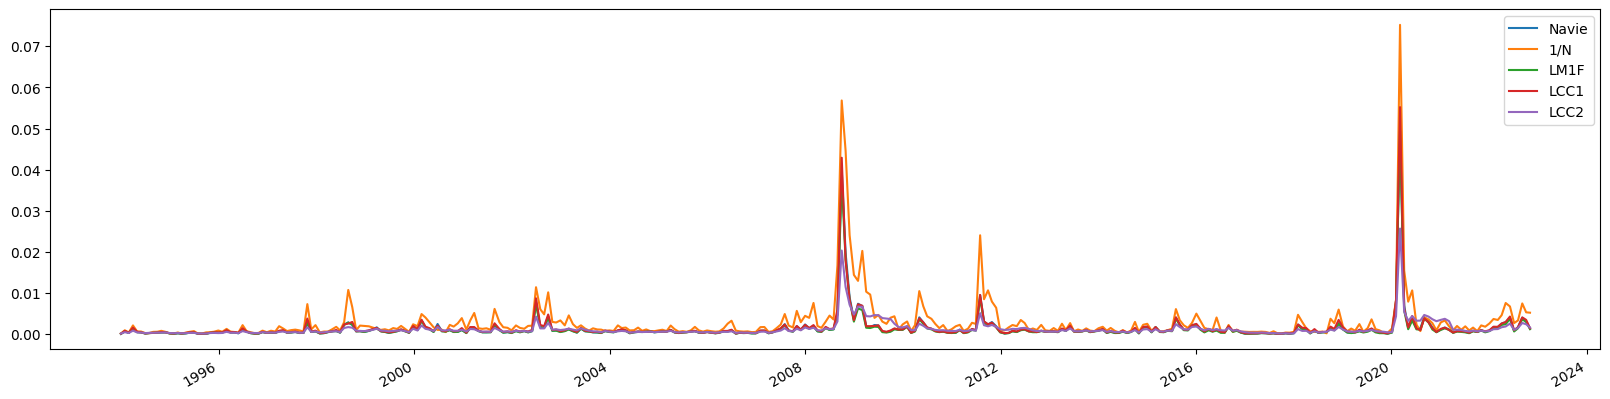

In [21]:
date = list(df.index)[250::21][:-1]
var_plot.index = date
var_plot.plot(figsize=(20,5))

<AxesSubplot:>

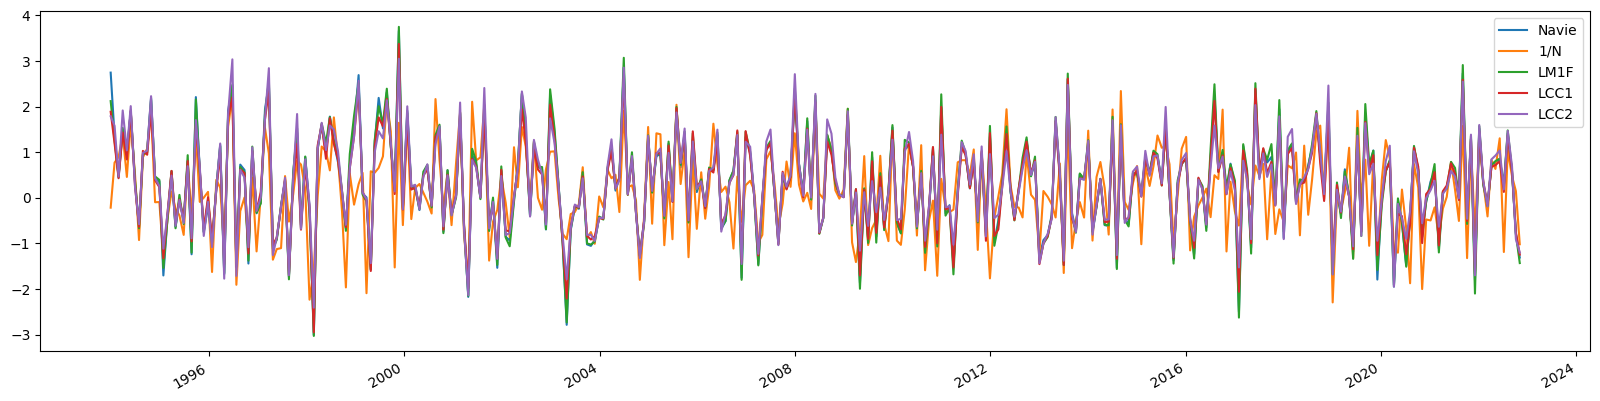

In [22]:
sharpe_ratio_plot.index = date
sharpe_ratio_plot.plot(figsize=(20,5))